# Processing Real estate transactions dataset 

In [ ]:
import sys
!{sys.executable} -m pip install geodatasets
!{sys.executable} -m pip install folium>=0.12
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install mapclassify
!{sys.executable} -m pip install h3

In [1]:
import os
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import geodatasets
import h3
from shapely.geometry import Polygon

## Downloading directly 

In [2]:
# The data contains lots of information (see below). We keep only the relevant ones for our needs 
relev_cols=['anneemut','datemut','valeurfonc','coddep','sbati','sterr','geompar_x','geompar_y','libtypbien']

In [ ]:
# WARNING : the file is relatively large, so this can take some time
# Online version 
url = 'https://minio.lab.sspcloud.fr/tomvxz/diffusion/transac.parquet'
df_reduced = pd.read_parquet(url, columns=relev_cols)

In [ ]:
# Offline version if available. Run this if you have downloaded the file localy already for future uses
#df_reduced = pd.read_parquet('transac.parquet',columns=relev_cols)

## Dictionary of variables - Dataset DV3F (Cerema)


Explaination from the variables come from here, they were formatted by ChatGPT : https://doc-datafoncier.cerema.fr/doc/dv3f/mutation. Most of them are useless in this case

This dataset comes from the **French Property Transaction Database (DVF – Demandes de Valeurs Foncières)** processed by **Cerema**. It records **real estate transactions carried out for consideration** (sales, exchanges, auctions).

### 1. Identifiers and References
These keys ensure row uniqueness or allow joins with other datasets (Land Registry / MAJIC files).

| Column | Description |
| :--- | :--- |
| **`idmutation`** | Unique transaction identifier (generated by Cerema). |
| `idmutinvar` | Stable identifier used to join with Land Registry (MAJIC) files. |
| `idopendata` | Original identifier from the raw DVF file (DGFiP). |
| `codservch` | Code of the Land Registration Office (SPF). |
| `refdoc` | Publication reference (Volume / Number). |

### 2. Transaction Date and Nature

| Column | Description |
| :--- | :--- |
| **`datemut`** | Exact date of the transaction. |
| `anneemut` | Year of the transaction. |
| `moismut` | Month of the transaction. |
| `idnatmut` | Code describing the nature of the transaction (1 = Sale, etc.). |
| **`libnatmut`** | Label describing the nature (e.g. *Sale*, *Sale of a property under construction*). |
| **`vefa`** | Boolean indicator: Sale of a Property Under Construction (new housing). |
| `nbartcgi` | Number of tax code articles applied. |
| `l_artcgi` | List of applicable tax code articles. |
| `nbdispo` | Number of legal provisions included in the deed. |

### 3. Geographic Location

| Column | Description |
| :--- | :--- |
| `coddep` | Department code (e.g. 75, 59). |
| `nbcomm` | Number of municipalities involved. |
| `l_codinsee` | List of INSEE municipality codes. |
| `nbsection` / `l_section` | Number and list of cadastral sections. |
| `nbpar` / `l_idpar` | Number and list of parcel identifiers involved. |
| `nbparmut` / `l_idparmut` | Number and list of parcels **actually transferred**. |
| `geompar_x` / `geompar_y` | Geographic coordinates (centroids). |

### 4. Price and Land (Plot Characteristics)

| Column | Description |
| :--- | :--- |
| **`valeurfonc`** | **Total transaction value** (net of seller). *Sum for all properties included in the transaction.* |
| `sterr` | Total land area (m²). |
| `l_dcnt` | List of cadastral land areas. |
| `nbsuf` | Number of land surfaces (link with Land Registry files). |

### 5. Building Characteristics (General)

| Column | Description |
| :--- | :--- |
| `codtypbien` | Property typology code (computed by Cerema). |
| **`libtypbien`** | Typology label (e.g. *House*, *Existing apartment*, *Building land*). |
| **`sbati`** | Total built surface area (m²) for all premises. |
| `nblot` | Number of condominium lots. |
| `nbvolmut` | Number of volumes transferred. |
| `nblocmut` | Total number of premises transferred. |
| `l_idlocmut` | List of premises identifiers. |

### 6. Breakdown by Type of Premises
Distribution of premises by category and associated surface areas.

| Column (Count) | Column (Surface) | Description |
| :--- | :--- | :--- |
| `nblocmai` | `sbatmai` | Number and built area of **Houses**. |
| `nblocapt` | `sbatapt` | Number and built area of **Apartments**. |
| `nblocact` | `sbatact` | Number and built area of **Commercial / Activity premises**. |
| `nblocdep` | – | Number of isolated **Outbuildings**. |

### 7. Breakdown by Number of Rooms (Housing Units)
Detail by number of main rooms.  
*Note: `5pp` corresponds to “5 rooms or more”.*

| Type | Counts | Surface Areas (m²) |
| :--- | :--- | :--- |
| **Apartments** | `nbapt1pp` to `nbapt5pp` | `sapt1pp` to `sapt5pp` |
| **Houses** | `nbmai1pp` to `nbmai5pp` | `smai1pp` to `smai5pp` |

---

> **Important note for analysis:**  
> The **`valeurfonc`** variable represents the **total value of the transaction** (`idmutation`).  
> If a single row includes multiple properties (e.g. a building with `nblocapt = 10` apartments), the recorded value corresponds to the **total price of the building**, not the price per apartment.


## Cleaning the dataset

### Removing weird values

In [4]:
#Checking for na values and non-relevant ones 
na_price = df_reduced['valeurfonc'].loc[df_reduced['valeurfonc'].isna()].count()
print('Nan price: ' + na_price.astype(str))

na_price = df_reduced['valeurfonc'].loc[df_reduced['valeurfonc']==0].count()
print('Null price: ' + na_price.astype(str))

zero_surf = df_reduced['sbati'].loc[df_reduced['sbati']==0].count()
print('Transactions with 0 m2: '+ zero_surf.astype(str))

nbr_trans = df_reduced['valeurfonc'].count()
print('Number of transactions: '+nbr_trans.astype(str))

Nan price: 0
Null price: 5288
Transactions with 0 m2: 4602780
Number of transactions: 15726683


This is a lot of transactions, but with 0 as the size of the built part, there are either errors or terrains such as fields. So we decide to remove them. Keeping them creates also very weird results in what follows, which is expected.

In [25]:
# Following previous anaylysis, we clean the data 

# Removing irrelevant transactions based on price
view_price = df_reduced.loc[:,'valeurfonc']
view_geo = df_reduced.loc[:,'geompar_x']
view_surf = df_reduced.loc[:,'sbati'] 
filter =  (view_price.isna()) | (view_geo.isna()) | (view_surf == 0) | (view_surf == 1) | (view_price == 0)
df_cleaned = df_reduced[~filter].copy()


In [6]:
# We check the other columns 
for col in relev_cols:
    print(df_cleaned[col].isna().sum())

0
0
0
0
0
0
0
0
0


In [7]:
# We check for weird case that could happen else than na values
print(df_cleaned['anneemut'].min(),df_cleaned['anneemut'].max()) #Checking the range of years
print(df_cleaned['datemut'].min(),df_cleaned['datemut'].max()) #Checking concistency with years
print(df_cleaned['valeurfonc'].min(),df_cleaned['valeurfonc'].max()) #Checking range of prices
print(df_cleaned['sbati'].min(),df_cleaned['sbati'].max()) #Checkin range of surfaces

2014 2025
2014-01-01 2025-06-30
0.11 14149999600.0
2.0 706238.0


We see that the range of prices is very large and still has values close to 0 (which probably corresponds to things like donation), so we want to remove extreme ones.

### Checking the values of department codes

In [8]:
df_cleaned['coddep'].unique() # Checking coherent dep codes

array(['79', '51', '45', '92', '86', '87', '93', '44', '50', '78', '46',
       '52', '85', '91', '90', '84', '53', '47', '43', '80', '94', '95',
       '81', '56', '42', '54', '40', '83', '82', '69', '41', '55', '32',
       '26', '27', '33', '2A', '19', '25', '31', '30', '24', '18', '2B',
       '34', '8', '9', '35', '21', '37', '23', '22', '36', '13', '7', '6',
       '12', '38', '4', '10', '11', '5', '39', '1', '15', '29', '28',
       '14', '16', '2', '3', '17', '58', '70', '64', '972', '973', '65',
       '71', '59', '73', '971', '72', '66', '62', '76', '89', '974', '88',
       '77', '63', '75', '61', '49', '48', '60', '74'], dtype=object)

In [9]:
df_reduced["coddep"].nunique()
#for a weird reason there seems to be only 97 departments in this dataset, without further time to inquire about the reasons of this, we will just ignore this problem

97

### Handling the values of transactions to remove extreme cases

We first look at the repartition of the log price of the transactions. The log allows to get a readable graph. 

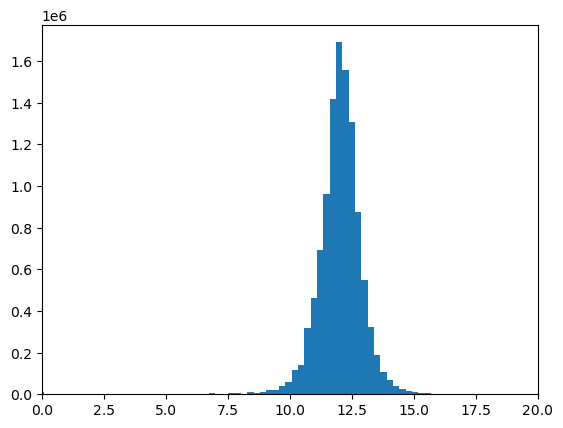

In [10]:
# Creating bins with numpy for faster computations
counts, bin_edges = np.histogram(np.log(df_cleaned['valeurfonc']), bins=100)

# We look at a barplot of the log of valeurfonc to have an idea of the values
plt.bar(bin_edges[:-1], counts, width=np.diff(bin_edges), align='edge')
plt.xlim([0,20])
plt.show()

Based on this, we decide to remove transactions of which the log of price is above 15 or below 7.5.

In [26]:
# Removing extreme price values
df_cleaned = df_cleaned[(np.log(df_cleaned['valeurfonc'])<=15) & (np.log(df_cleaned['valeurfonc'])>=7.5)]

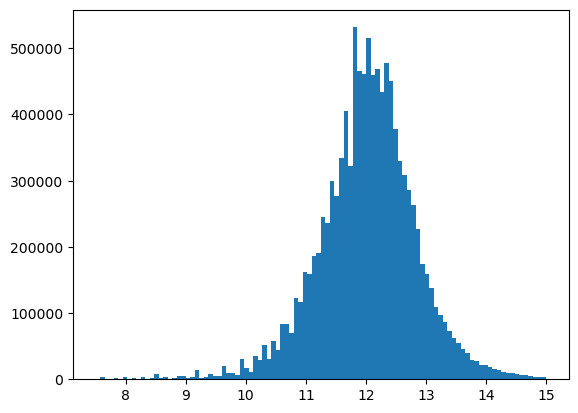

In [12]:
# Creating bins with numpy for faster computations
counts, bin_edges = np.histogram(np.log(df_cleaned['valeurfonc']), bins=100)

# We look at a barplot of the log of valeurfonc to have an idea of the values
plt.bar(bin_edges[:-1], counts, width=np.diff(bin_edges), align='edge')
plt.show()

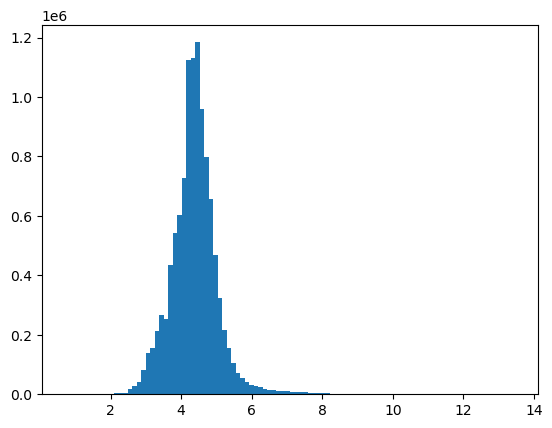

In [14]:
# Creating bins with numpy for faster computations
counts, bin_edges = np.histogram(np.log(df_cleaned['sbati']), bins=100)

# We look at a barplot of the log of valeurfonc to have an idea of the values
plt.bar(bin_edges[:-1], counts, width=np.diff(bin_edges), align='edge')
plt.show()

### Creation of price per meter squared

In [27]:
# Since valeurfonc is highly dependant on the size of the building/house sold, we look at price/m2
# We choose to divide first by the built surface (other approches to come)
df_cleaned.loc[:,'p/m2']=df_cleaned['valeurfonc']/df_cleaned['sbati']

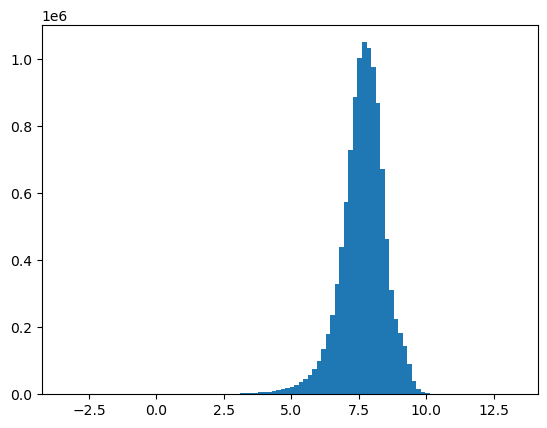

In [28]:
# Creating bins with numpy for faster computations
counts, bin_edges = np.histogram(np.log(df_cleaned['p/m2']), bins=100)

# We look at a barplot of the log of valeurfonc to have an idea of the values
plt.bar(bin_edges[:-1], counts, width=np.diff(bin_edges), align='edge')
plt.show()

In [29]:
filter_pm2 = (np.log(df_cleaned['p/m2'])>=3) & (np.log(df_cleaned['p/m2'])<=10)
df_cleaned = df_cleaned[filter_pm2]

The repartition makes now much more sense

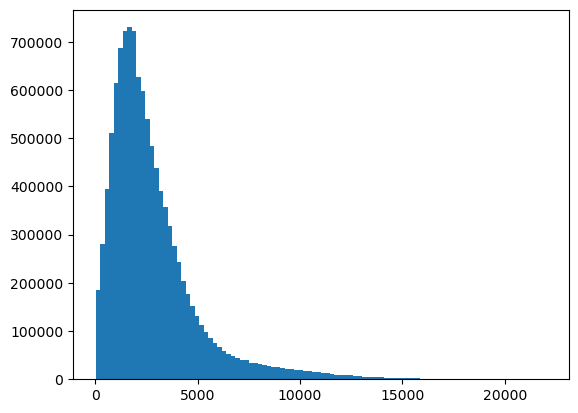

In [31]:
# Creating bins with numpy for faster computations
counts, bin_edges = np.histogram(df_cleaned['p/m2'], bins=100)

# We look at a barplot of the log of valeurfonc to have an idea of the values
plt.bar(bin_edges[:-1], counts, width=np.diff(bin_edges), align='edge')
plt.show()

### Usage of building

In [ ]:
df_cleaned['libtypbien'].unique()

array(['UNE MAISON', 'UN APPARTEMENT', 'DES MAISONS', 'ACTIVITE',
       'BATI MIXTE - LOGEMENTS', 'BATI MIXTE - LOGEMENT/ACTIVITE',
       'APPARTEMENT INDETERMINE', 'DEUX APPARTEMENTS',
       'BATI - INDETERMINE : Vente avec volume(s)',
       'MAISON - INDETERMINEE', 'UNE DEPENDANCE', 'DES DEPENDANCES'],
      dtype=object)

We also have access to the nature of the good being traded, which we could potentially use to be more precise.

## Vizualization

We create the geopandas dataframe to easily draw maps. The caveat is that the given coordinates in the dataframe use different systems depending on the zone. For instance, in France, the system used is Lambert 93 and we have to convert that to the classic GPS system that is widely used. 

In [35]:
# Geopandas

projections = {
    "Metro":  "EPSG:2154",  # Lambert 93 (France entière hors DOM)
    "971":    "EPSG:5490",  # Guadeloupe (UTM 20N)
    "972":    "EPSG:5490",  # Martinique (UTM 20N)
    "973":    "EPSG:2972",  # Guyane (UTM 22N)
    "974":    "EPSG:2975",  # La Réunion (UTM 40S)
    "976":    "EPSG:4471",   # Mayotte
}

parts = []

#Handling each zones (DOM/TOM have specific zones)
for zone, epsg_code in projections.items():
    if zone == "Metro":
        # Everything that is not a DOM/TOM
        subset = df_cleaned.loc[~((df_cleaned['coddep'].str.startswith('97')) | (df_cleaned['coddep'].isin(['13', '26'])))]
    else:
        # Take specific zone
        subset = df_cleaned.loc[df_cleaned['coddep'] == zone]
    
    if not subset.empty:
        gdf_subset = gpd.GeoDataFrame(
            subset,
            geometry=gpd.points_from_xy(subset['geompar_x'], subset['geompar_y']),
            crs=epsg_code
        )
        
        # Converting to GPS coordinates
        gdf_subset = gdf_subset.to_crs("EPSG:4326")
        
        parts.append(gdf_subset)

gdf_final = pd.concat(parts)



In [33]:
# We check that our geometries are non-empty
print(gdf_final.geometry.is_empty.sum()) 

0


In [37]:
gdf_final.sample(100).explore()

## Per department

In [38]:
gdf_final["coddep"] = gdf_final["coddep"].str.zfill(2)

In [39]:
gdf_final["coddep"].nunique()

95

Out of the 97 departments that were imported at the beginning (105 minus 5 DOM, 3 "Alsace-Lorraine" dep.), 2 of them have disappeared due to cleaning

### Number of real_estate transactions per person

In [40]:
# First, we groupby for each department by numbers of transactions
nb_transac_per_dep = gdf_final.groupby("coddep").size().reset_index(name='Number_transactions')
nb_transac_per_dep.to_csv("nb_transac_per_dep.csv")

In [41]:
def deps_pop_init():
    deps_pop = pd.read_excel("https://www.insee.fr/fr/statistiques/fichier/2012713/TCRD_004.xlsx")
    deps_pop.columns = deps_pop.iloc[2]
    deps_pop = deps_pop.iloc[3:]
    deps_pop = deps_pop.reset_index()
    deps_pop.columns = ["to_del", "code", "deps_name", "2025", "share_pop","2022", "2016","2011","1999"]
    deps_pop.set_index("code")
    deps_pop = deps_pop.loc[0:101,["code","2011","2025"]]
    return deps_pop

deps_pop = deps_pop_init()

In [42]:
def add_department_pop(df):
    df = df.reset_index()
    df = df.merge(
        deps_pop[["code", "2011", "2025"]],
        left_on="coddep",
        right_on="code",
        how="left"
    )
    df = df.drop(columns=["code"]).set_index("coddep")
    return df

In [43]:
deps = gpd.read_file("https://raw.githubusercontent.com/gregoiredavid/france-geojson/master/departements.geojson")

def add_department_name(df):
    df = df.merge(
        deps[["code", "nom"]],
        left_on="coddep",
        right_on="code",
        how="left"
    )

    df["coddep"] = (
        df["code"].astype(str) + " - " + df["nom"]
    )

    df = (
        df
        .drop(columns=["code", "nom"])
        .set_index("coddep")
    )

    return df

In [44]:
nb_transac_per_dep = nb_transac_per_dep[["coddep","Number_transactions"]]
nb_transac_per_dep.rename(columns={"coddep": "Code du département du lieu des travaux - Code de la zone"})
nb_transac_per_pop_dep = add_department_pop(nb_transac_per_dep)
nb_transac_per_pop_dep["transac_freq"] =  nb_transac_per_pop_dep["Number_transactions"]/nb_transac_per_pop_dep["2025"]


In [45]:
add_department_name(nb_transac_per_pop_dep["transac_freq"].sort_values(ascending=False).to_frame().head(10))


,transac_freq
coddep,
05 - Hautes-Alpes,0.288101
06 - Alpes-Maritimes,0.269516
66 - Pyrénées-Orientales,0.250549
73 - Savoie,0.243292
83 - Var,0.236127
11 - Aude,0.234217
17 - Charente-Maritime,0.227958
34 - Hérault,0.216808
74 - Haute-Savoie,0.215808


Number of real estate transactions per population could be an indicator of how intensive is the trading in a place, which could be an indicator of speculation, defined as buying a property to make monetary profit from the variation of price. 
However, population does not take into account secondary residency owned by non resident of a department. 


### Growth of p/m2

In [46]:
median_pm2_per_dep = gdf_final.groupby("coddep")["p/m2"].median().to_frame()
add_department_name(median_pm2_per_dep["p/m2"].sort_values(ascending=False).to_frame().head(10))

,p/m2
coddep,
75 - Paris,9284.210526
92 - Hauts-de-Seine,6250.000000
94 - Val-de-Marne,4492.753623
06 - Alpes-Maritimes,4061.270161
74 - Haute-Savoie,3755.102041
78 - Yvelines,3690.476190
93 - Seine-Saint-Denis,3670.211268
83 - Var,3335.000000
2A - Corse-du-Sud,3333.333333


In [47]:
pm2_growth_per_dep = gdf_final.groupby(["coddep","anneemut"])["p/m2"].median().unstack(1)
pm2_growth_per_dep

anneemut,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
coddep,,,,,,,,,,,,
01,1914.893617,1867.489837,1867.469880,1924.050633,1982.058824,2017.391304,2113.663056,2278.333333,2504.808137,2472.972973,2388.059701,2431.443299
02,1087.007673,1064.814815,1048.387097,1076.923077,1081.466733,1087.068004,1117.647059,1173.333333,1233.644860,1180.314961,1161.875000,1171.733212
03,974.576271,935.483871,947.410256,944.444444,944.444444,970.944140,1000.000000,1008.119452,1104.031385,1093.750000,1108.033346,1136.363636
04,1804.267738,1769.230769,1854.700855,1818.181818,1722.222222,1775.421348,1875.000000,1925.312500,2062.780269,2202.885391,2146.082976,2188.841202
05,2118.443656,2076.923077,2041.958042,2017.241379,2013.008130,2066.086957,2114.201681,2257.142857,2431.034483,2594.951923,2624.418605,2662.962963
...,...,...,...,...,...,...,...,...,...,...,...,...
95,3000.000000,2957.746479,2925.170068,3000.000000,3080.000000,3181.818182,3307.692308,3496.153846,3658.108345,3529.411765,3307.692308,3279.674451
971,2000.000000,2038.834951,2131.481481,2198.484848,2169.863014,2333.333333,2500.000000,2545.927273,2750.000000,2931.203516,2857.142857,2500.000000
972,2013.888889,2117.647059,2152.941176,2205.882353,2195.832137,2250.000000,2392.857143,2413.793103,2542.372881,2459.161662,2538.497986,2728.695093


In [48]:
pm2_growth_per_dep = pm2_growth_per_dep.pct_change(axis=1)
pm2_growth_per_dep = pm2_growth_per_dep.quantile(0.9,axis=1).to_frame()
pm2_growth_per_dep

,0.9
coddep,
01,0.077908
02,0.049825
03,0.029925
04,0.067921
05,0.067610
...,...
95,0.046324
971,0.075337
972,0.063492


In [49]:
add_department_name(pm2_growth_per_dep[0.9].sort_values(ascending=False).to_frame()).head(10)

,0.9
coddep,
29 - Finistère,0.128906
56 - Morbihan,0.114691
49 - Maine-et-Loire,0.108325
35 - Ille-et-Vilaine,0.104497
85 - Vendée,0.100799
40 - Landes,0.092810
44 - Loire-Atlantique,0.092222
22 - Côtes-d'Armor,0.091954
14 - Calvados,0.087759


In [50]:
pm2_growth_pop_per_dep = add_department_pop(pm2_growth_per_dep)
pm2_growth_pop_per_dep["pop_growth"] = (pm2_growth_pop_per_dep["2025"]-pm2_growth_pop_per_dep["2011"])/pm2_growth_pop_per_dep["2025"]

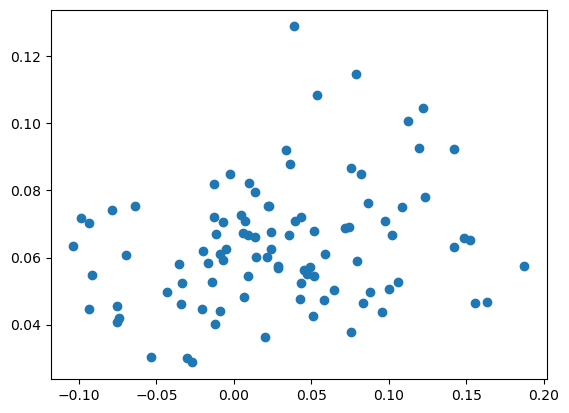

In [51]:
plt.scatter(
    pm2_growth_pop_per_dep["pop_growth"],
    pm2_growth_pop_per_dep[0.9]
)

Departments where there was high increases of prices during the period are not departments that had high level of population growth

What if we look at the "average" (we will here take median as the dataset contains extremely low and extremely high values) growth rate of prices during the period ? 


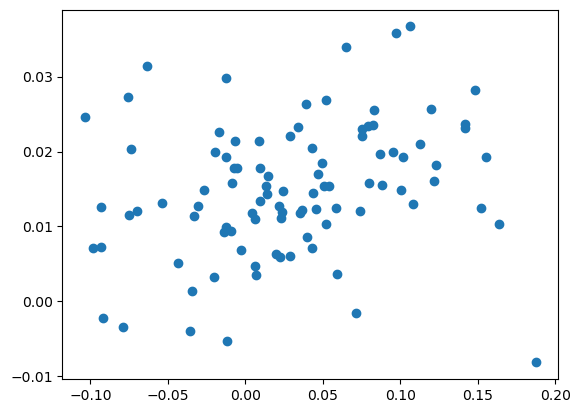

In [52]:
pm2_growth_per_dep = gdf_final.groupby(["coddep","anneemut"])["p/m2"].median().unstack(1)
pm2_growth_per_dep = pm2_growth_per_dep.pct_change(axis=1)
pm2_growth_per_dep = pm2_growth_per_dep.quantile(0.5,axis=1).to_frame()
add_department_name(pm2_growth_per_dep[0.5].sort_values(ascending=False).to_frame()).head(10)
pm2_growth_pop_per_dep = add_department_pop(pm2_growth_per_dep)
pm2_growth_pop_per_dep["pop_growth"] = (pm2_growth_pop_per_dep["2025"]-pm2_growth_pop_per_dep["2011"])/pm2_growth_pop_per_dep["2025"]
plt.scatter(
    pm2_growth_pop_per_dep["pop_growth"],
    pm2_growth_pop_per_dep[0.5]
)

In [53]:
add_department_name(pm2_growth_pop_per_dep.loc[pm2_growth_pop_per_dep[0.5]>0.06])


,0.5,2011,2025,pop_growth
coddep,,,,


These are the departments where median price growth over the period was the highest, despite normal or even negative population growth. These departments do not seem to have any distinctive feature

In [54]:
pm2_growth_per_dep = gdf_final.groupby(["coddep","anneemut"])["p/m2"].median().unstack(1)
pm2_growth_per_dep.iloc[18:45,]


anneemut,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
coddep,,,,,,,,,,,,
21,1802.693714,1800.000000,1777.777778,1836.867347,1857.142857,1935.483871,2049.816176,2196.187364,2333.333333,2257.359307,2209.046474,2235.294118
22,1288.888889,1255.597327,1277.777778,1296.296296,1326.530612,1375.200000,1450.000000,1583.333333,1793.156662,1864.301328,1888.888889,1931.034483
23,714.285714,669.002217,663.265306,681.148485,652.919501,638.426045,657.290506,672.564916,739.130435,770.057471,785.714286,759.493671
24,1197.723765,1192.483660,1201.134788,1214.285714,1244.269466,1250.000000,1301.369863,1388.888889,1513.513514,1562.500000,1515.151515,1513.878470
25,1588.311195,1591.153470,1578.947368,1642.125866,1660.000000,1653.345576,1723.076923,1845.333333,2000.000000,1933.157051,1884.615385,1900.704225
27,1590.527538,1575.000000,1541.264927,1567.796610,1607.142857,1600.000000,1666.666667,1796.875000,1932.432432,1937.349398,1835.841006,1856.190476
28,1663.664596,1609.375000,1571.428571,1624.252336,1574.074074,1634.146341,1673.684211,1754.493596,1863.333333,1857.375776,1791.555258,1800.000000
29,1339.285714,1333.333333,1333.333333,1368.421053,1395.111509,1440.183486,1568.627451,1770.833333,2018.961179,2088.235294,2070.422535,2063.809524
2A,2965.517241,2976.777560,3000.000000,3113.484848,3125.000000,3201.821843,3244.562648,3593.750000,3760.851064,3778.499278,3851.351351,3934.102235


We remark that these are departments where there are not a lot of datas : the outliers seems to be statistical artefact 

In [ ]:
pm2_growth_per_dep = gdf_final.groupby(["coddep","anneemut"])["p/m2"].median().unstack(1)
pm2_growth_per_dep = pm2_growth_per_dep.pct_change(axis=1)
pm2_growth_per_dep = pm2_growth_per_dep.mean(axis=1).to_frame()
add_department_name(pm2_growth_per_dep[0].sort_values(ascending=False).to_frame()).head(10)
pm2_growth_pop_per_dep = add_department_pop(pm2_growth_per_dep)
pm2_growth_pop_per_dep["pop_growth"] = (pm2_growth_pop_per_dep["2025"]-pm2_growth_pop_per_dep["2011"])/pm2_growth_pop_per_dep["2025"]

plt.scatter(
    pm2_growth_pop_per_dep["pop_growth"],
    pm2_growth_pop_per_dep[0]
)

## Per hexagon

In [ ]:
# 1. Configuration
# Note : Résolution 3 est très vaste (échelle régionale). 
# Pour des quartiers, visez plutôt 7, 8 ou 9.
resolution = 7

# ---------------------------------------------------------
# OPTIMISATION 1 : Assigning a hexagon to every transaction 
# ---------------------------------------------------------

# On extrait les colonnes en tableaux NumPy purs (.values)
# C'est beaucoup plus rapide que d'accéder à geometry.x ligne par ligne
lats = gdf_final.geometry.y.values
lons = gdf_final.geometry.x.values

# On utilise une compréhension de liste avec zip
# C'est la méthode standard la plus rapide en Python pur
gdf_final['h3_index'] = [
    h3.latlng_to_cell(lat, lon, resolution) 
    for lat, lon in zip(lats, lons)
]


In [ ]:
# ---------------------------------------------------------
# OPTIMISATION 2 : Reconstructing the geometry of the h3-hexagon
# ---------------------------------------------------------

def hex_to_poly_optimized(h3_id):
    # cell_to_boundary renvoie ((lat, lon), (lat, lon)...)
    points = h3.cell_to_boundary(h3_id)
    # Inversion (Lat, Lon) -> (Lon, Lat) + Création Polygon
    return Polygon([(lng, lat) for lat, lng in points])

def display_hexagon_map(df_counts,variable):
    # Ici aussi, on évite .apply() pour utiliser une boucle de liste directe
    #we create a geodataframe that assign a geometry to every hexagon
    gdf_h3 = gpd.GeoDataFrame(
        df_counts,
        geometry=[hex_to_poly_optimized(h_id) for h_id in df_counts['h3_index'].values],
        crs="EPSG:4326"
    )

    #displaying the hexagon
    m = gdf_h3.explore(
        column=variable,
        cmap="inferno",
        style_kwds={"fillOpacity": 0.6, "weight": 0},
        tiles="CartoDB positron"
    )
    return m

### Number of transactions per hexagon

In [ ]:
variable = "Number of transactions"
df_counts = gdf_final.groupby('h3_index').size().reset_index(name='Number_transactions')
display_hexagon_map(df_counts, variable)


### Median price of a transation per hexagon

In [ ]:
variable = "Median price of transactions"
df_counts = gdf_final.groupby('h3_index')['valeurfonc'].median().reset_index(name=variable)
display_hexagon_map(df_counts, variable)

### Median p/m2 per hexagon

In [ ]:
gdf_final = gdf_final[gdf_final['p/m2'] < np.inf]

In [ ]:
variable = "Median p/m2"
df_counts = gdf_final.groupby('h3_index')['p/m2'].median().reset_index(name=variable)
display_hexagon_map(df_counts, variable)

### Time-series analysis 

#### Nb of constructions

In [ ]:
gdf_final.groupby('h3_index').size().reset_index(name='Number_transactions')

#### Median p/m2

In [ ]:
gdf_final

In [ ]:
gdf_final = gdf_final.loc[gdf_final['p/m2']<50000,]


In [ ]:
gdf_final = gdf_final[gdf_final['p/m2'] < np.inf]
gdf_final.head()

In [ ]:
pm2_growth_per_hex = gdf_final.groupby(['h3_index','anneemut'])['p/m2'].median().unstack(1)
pm2_growth_per_hex =pm2_growth_per_hex.pct_change()
# log growth : pm2_growth_per_hex = np.log1p(pm2_growth_per_hex).diff(axis=1)

    
pm2_growth_per_hex

In [ ]:
pm2_growth_per_hex = pm2_growth_per_hex.median(axis=1).dropna().sort_values(ascending=False).reset_index()


In [ ]:
pm2_growth_per_hex.loc[pm2_growth_per_hex[0]<1].plot.hist(bins=200)
plt.show()

In [ ]:
pm2_growth_per_hex.loc[pm2_growth_per_hex[0]>4,]

In [ ]:
pm2_growth_per_hex.to_csv("pm2_growth_per_hex.csv")